In [300]:
import numpy as np

import torch.nn as nn 
import torch.optim as optim

from typing import *
from inspect import signature

import matplotlib.pyplot as plt

In [301]:
def plot_signal(sample_points: np.ndarray, signal_matrix: np.ndarray, label: str = "Sinais com ruído") -> None:
    """
    Plota um conjunto de sinais.

    Args:
        sample_points (np.ndarray): lista de pontos do domínio
        signal_matrix (np.ndarray): matriz de sinais com amostragens para os valores do sinal em cada ponto
        label (str, optional): Título do plot. Defaults to "Sinais com ruído".
    """
    plt.plot(sample_points, signal_matrix)
    plt.title(label)
    plt.xlabel("Tempo")
    plt.ylabel("Amplitude")

In [302]:
def get_f():
    r = np.random.normal
    functions = (
        np.sin,
        np.cos,
        #lambda x: np.sin(x*r()) + np.cos(x*r()),
        #lambda x: np.sin(x*r()) - np.cos(x*r()),
        #lambda x: np.sin(x*r()) * np.cos(x*r())
    )
    
    f = np.random.choice(functions)
    
    return f

In [303]:
def add_noise(signal_vector: np.ndarray, level: float = 0.05, mean: float = 0, std: float = 1) -> float:
    n = signal_vector.size
    return signal_vector + (np.random.normal(mean, std, size=(n)) * level)


def generate_signal_vector(f: Callable, sample_points: np.ndarray) -> np.ndarray:
    return f(sample_points)
    
    
def generate_signal_matrix(
    get_f: Callable,
    n_signals: int,
    sample_points: np.ndarray,
):
    n_points = sample_points.size
    
    m = np.zeros((n_points, n_signals))
    for i in range(n_signals):
        f = get_f()
        m[:, i] = generate_signal_vector(f, sample_points)
    
    return m


def generate_sample_points(start: float, stop: float, step: float) -> np.ndarray:
    return np.arange(start, stop, step)

In [304]:
start = 0
stop = 10
step = 0.1

sample_points = generate_sample_points(start, stop, step)

sample_points.size

100

In [305]:
# plot_signal(sample_points, signals_matrix)

In [306]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 100)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [307]:
autoencoder = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [308]:
n_samples = 100
signals_matrix = generate_signal_matrix(get_f, n_samples, sample_points)

signals = torch.tensor(signals_matrix, dtype=torch.float32)

In [309]:
n_epochs = 1000
for epoch in range(n_epochs):
    outputs = autoencoder(signals)
    loss = criterion(outputs, signals)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 2 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')
        

Epoch [2/1000], Loss: 0.5042
Epoch [4/1000], Loss: 0.5016
Epoch [6/1000], Loss: 0.4992
Epoch [8/1000], Loss: 0.4971
Epoch [10/1000], Loss: 0.4953
Epoch [12/1000], Loss: 0.4935
Epoch [14/1000], Loss: 0.4918
Epoch [16/1000], Loss: 0.4902
Epoch [18/1000], Loss: 0.4885
Epoch [20/1000], Loss: 0.4866
Epoch [22/1000], Loss: 0.4844
Epoch [24/1000], Loss: 0.4814
Epoch [26/1000], Loss: 0.4772
Epoch [28/1000], Loss: 0.4716
Epoch [30/1000], Loss: 0.4644
Epoch [32/1000], Loss: 0.4550
Epoch [34/1000], Loss: 0.4435
Epoch [36/1000], Loss: 0.4300
Epoch [38/1000], Loss: 0.4137
Epoch [40/1000], Loss: 0.3948
Epoch [42/1000], Loss: 0.3737
Epoch [44/1000], Loss: 0.3529
Epoch [46/1000], Loss: 0.3365
Epoch [48/1000], Loss: 0.3242
Epoch [50/1000], Loss: 0.3092
Epoch [52/1000], Loss: 0.2955
Epoch [54/1000], Loss: 0.2858
Epoch [56/1000], Loss: 0.2735
Epoch [58/1000], Loss: 0.2625
Epoch [60/1000], Loss: 0.2535
Epoch [62/1000], Loss: 0.2447
Epoch [64/1000], Loss: 0.2400
Epoch [66/1000], Loss: 0.2357
Epoch [68/1000

In [310]:
v = generate_signal_vector(np.sin, sample_points)

In [311]:
v_noisy = add_noise(v)

In [312]:
v

array([ 0.        ,  0.09983342,  0.19866933,  0.29552021,  0.38941834,
        0.47942554,  0.56464247,  0.64421769,  0.71735609,  0.78332691,
        0.84147098,  0.89120736,  0.93203909,  0.96355819,  0.98544973,
        0.99749499,  0.9995736 ,  0.99166481,  0.97384763,  0.94630009,
        0.90929743,  0.86320937,  0.8084964 ,  0.74570521,  0.67546318,
        0.59847214,  0.51550137,  0.42737988,  0.33498815,  0.23924933,
        0.14112001,  0.04158066, -0.05837414, -0.15774569, -0.2555411 ,
       -0.35078323, -0.44252044, -0.52983614, -0.61185789, -0.68776616,
       -0.7568025 , -0.81827711, -0.87157577, -0.91616594, -0.95160207,
       -0.97753012, -0.993691  , -0.99992326, -0.99616461, -0.98245261,
       -0.95892427, -0.92581468, -0.88345466, -0.83226744, -0.77276449,
       -0.70554033, -0.63126664, -0.55068554, -0.46460218, -0.37387666,
       -0.2794155 , -0.1821625 , -0.0830894 ,  0.0168139 ,  0.1165492 ,
        0.21511999,  0.31154136,  0.40484992,  0.49411335,  0.57

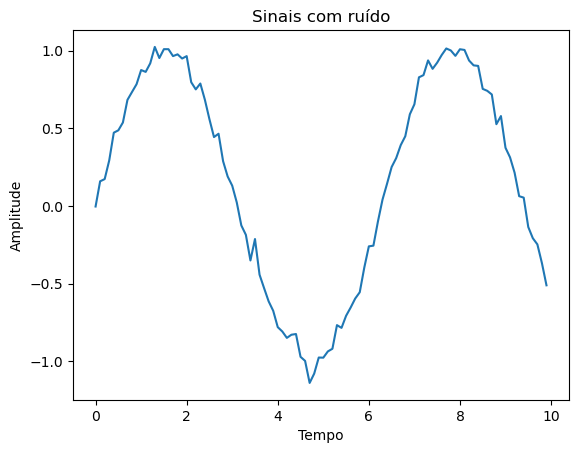

In [313]:
plot_signal(sample_points, v_noisy)

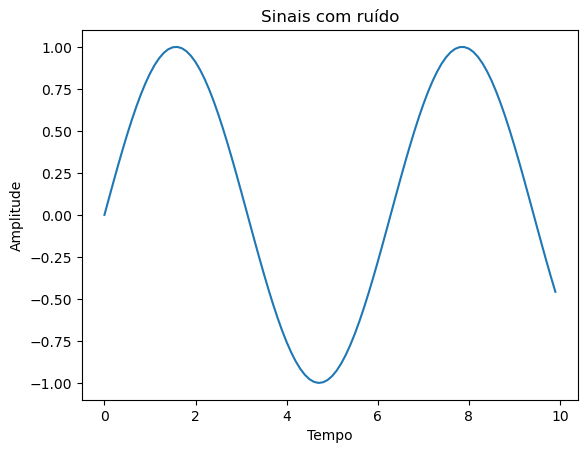

In [314]:
plot_signal(sample_points, v)

In [315]:
reconstructed = autoencoder(torch.tensor(v_noisy, dtype=torch.float32)).detach().numpy()

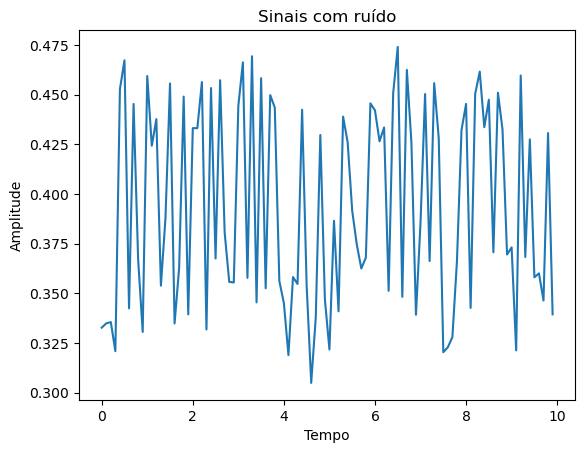

In [316]:
plot_signal(sample_points, reconstructed)

In [320]:
v

array([ 0.        ,  0.09983342,  0.19866933,  0.29552021,  0.38941834,
        0.47942554,  0.56464247,  0.64421769,  0.71735609,  0.78332691,
        0.84147098,  0.89120736,  0.93203909,  0.96355819,  0.98544973,
        0.99749499,  0.9995736 ,  0.99166481,  0.97384763,  0.94630009,
        0.90929743,  0.86320937,  0.8084964 ,  0.74570521,  0.67546318,
        0.59847214,  0.51550137,  0.42737988,  0.33498815,  0.23924933,
        0.14112001,  0.04158066, -0.05837414, -0.15774569, -0.2555411 ,
       -0.35078323, -0.44252044, -0.52983614, -0.61185789, -0.68776616,
       -0.7568025 , -0.81827711, -0.87157577, -0.91616594, -0.95160207,
       -0.97753012, -0.993691  , -0.99992326, -0.99616461, -0.98245261,
       -0.95892427, -0.92581468, -0.88345466, -0.83226744, -0.77276449,
       -0.70554033, -0.63126664, -0.55068554, -0.46460218, -0.37387666,
       -0.2794155 , -0.1821625 , -0.0830894 ,  0.0168139 ,  0.1165492 ,
        0.21511999,  0.31154136,  0.40484992,  0.49411335,  0.57

In [321]:
reconstructed

array([0.33269703, 0.33484656, 0.33549964, 0.32084915, 0.45270786,
       0.46720347, 0.34239945, 0.44524795, 0.3669517 , 0.33054706,
       0.45928824, 0.42422915, 0.43760502, 0.35382783, 0.387681  ,
       0.4555651 , 0.33479565, 0.36271015, 0.4489574 , 0.339369  ,
       0.43308184, 0.43306616, 0.45626542, 0.3317912 , 0.45325378,
       0.36749455, 0.45718983, 0.38042954, 0.35573474, 0.355435  ,
       0.44432583, 0.4661764 , 0.3577459 , 0.46924958, 0.34541643,
       0.45822948, 0.35250083, 0.44971186, 0.4434631 , 0.35618266,
       0.34501234, 0.31886005, 0.35815066, 0.35468084, 0.44235557,
       0.35373145, 0.30488616, 0.33782062, 0.4296366 , 0.34703016,
       0.32169956, 0.38645804, 0.34091514, 0.4388725 , 0.4259602 ,
       0.39154848, 0.3746026 , 0.36246505, 0.36797297, 0.44556096,
       0.44201073, 0.42645064, 0.4334339 , 0.35123214, 0.45082176,
       0.47394192, 0.34818378, 0.46238005, 0.42579827, 0.33917925,
       0.38552514, 0.4502392 , 0.3662137 , 0.45573127, 0.42802